In [1]:
from preprocessing import preprocess_flowdata, preprocess_graph
from dataset import WaterFlowDataSet
from model import Model
import torch
import hyperparameters as hp
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt

In [2]:
df_node_features, df_node_features_strata = preprocess_flowdata(hp.FLOWDATA_PATH)
edge_indices, edge_weights = preprocess_graph(hp.SUBSETGRAPH_PATH)

In [3]:
train_dataset = WaterFlowDataSet(df_node_features[0], df_node_features_strata[0], edge_indices, edge_weights, hp.FORECAST_WINDOW)
val_dataset = WaterFlowDataSet(df_node_features[1], df_node_features_strata[1], edge_indices, edge_weights, hp.FORECAST_WINDOW)
test_dataset = WaterFlowDataSet(df_node_features[2], df_node_features_strata[2], edge_indices, edge_weights, hp.FORECAST_WINDOW)

In [4]:
WIN_SIZE = hp.TOTAL_WINDOW

model = Model(
    input_channels = WIN_SIZE, 
    hidden_channels = WIN_SIZE, 
    output_channels = WIN_SIZE, 
    num_heads = 4, 
    embed_dim = 32,
    context_window = hp.CONTEXT_WINDOW,
    forecast_window = hp.FORECAST_WINDOW
)

optimiser = torch.optim.Adam(model.parameters(), lr=hp.LEARNING_RATE)
criterion = torch.nn.MSELoss()

In [5]:
def train(model, optimiser, loader):
    model.train()
    total_loss = 0

    for batch in loader:
        optimiser.zero_grad()
        out = model(batch.x, batch.edge_index) 
        loss = criterion(out[batch.mask], batch.y[batch.mask].squeeze())
        loss.backward()
        optimiser.step()
        total_loss += loss.item() * batch.num_graphs 

    return total_loss / len(loader.dataset)

def validate(model, loader):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for batch in loader:
            out = model(batch.x, batch.edge_index) 
            loss = criterion(out[batch.mask], batch.y[batch.mask].squeeze())
            total_loss += loss.item() * batch.num_graphs 
    
    return total_loss / len(loader.dataset)

In [6]:
train_loader = DataLoader(train_dataset, batch_size=hp.BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=hp.BATCH_SIZE, shuffle=True)

train_loss = []
val_loss = []

for epoch in range(50):
    epoch_train_loss = train(model, optimiser, train_loader)
    epoch_val_loss = validate(model, val_loader)
    train_loss.append(epoch_train_loss)
    val_loss.append(epoch_val_loss)
    print(f"Epoch {epoch+1}, Train Loss: {epoch_train_loss}, Val Loss: {epoch_val_loss}")

Epoch 1, Train Loss: 3.673421737125942, Val Loss: 1.000487756729126
Epoch 2, Train Loss: 0.9708331108093262, Val Loss: 0.6619494835535685
Epoch 3, Train Loss: 0.7094533698899406, Val Loss: 0.6290063381195068
Epoch 4, Train Loss: 0.7225476792880468, Val Loss: 0.7164734919865926
Epoch 5, Train Loss: 0.6974971107074193, Val Loss: 0.631013810634613
Epoch 6, Train Loss: 0.7062576413154602, Val Loss: 0.7175801197687784
Epoch 7, Train Loss: 0.6594273499080113, Val Loss: 0.6165108720461527
Epoch 8, Train Loss: 0.7044581856046405, Val Loss: 0.5737975001335144
Epoch 9, Train Loss: 0.6427182793617249, Val Loss: 0.6866094946861268
Epoch 10, Train Loss: 0.6593215176037379, Val Loss: 0.7377765695254008
Epoch 11, Train Loss: 0.7216235433306013, Val Loss: 0.7271420359611511
Epoch 12, Train Loss: 0.6781086427824837, Val Loss: 0.6851120154062907
Epoch 13, Train Loss: 0.6559923410415649, Val Loss: 0.6537115812301636
Epoch 14, Train Loss: 0.7096745082310267, Val Loss: 0.5664724151293437
Epoch 15, Train Lo

KeyboardInterrupt: 

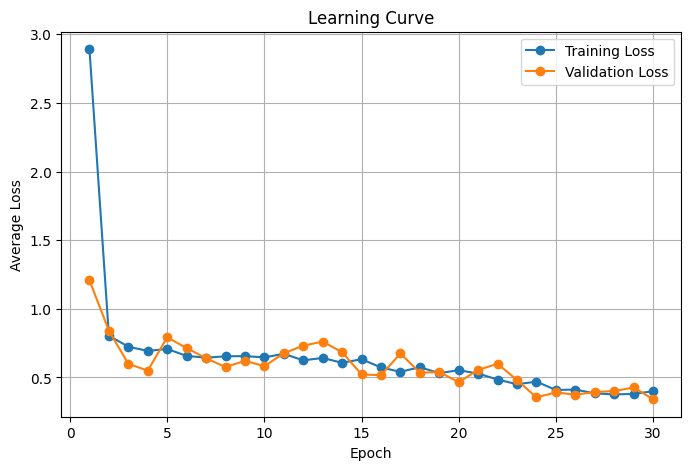

In [7]:
plt.figure(figsize=(8,5))

plt.plot(range(1, hp.NB_EPOCHS + 1), train_loss, marker='o', label='Training Loss')
plt.plot(range(1, hp.NB_EPOCHS + 1), val_loss, marker='o', label='Validation Loss')

plt.title('Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')

plt.grid(True)
plt.legend()
plt.show()

In [8]:
def calc_index_of_agreement(y_pred, y_actual, eps=1e-8):
    y_actual_mean = torch.mean(y_actual)

    numerator = torch.sum((y_pred - y_actual) ** 2)
    denominator = torch.sum((torch.abs(y_pred - y_actual_mean) + torch.abs(y_actual - y_actual_mean)) ** 2)
    
    index_of_agreement = 1 - numerator / (denominator + eps)
    return index_of_agreement



def test(model, loader):
    model.eval()
    total_loss = 0.0

    all_y_pred = []
    all_y_actual = []

    with torch.no_grad():
        for batch in loader:
            out = model(batch.x, batch.edge_index)
            mask = ~batch.mask 
            y_actual = batch.y[mask]

            if mask.sum() == 0:
                continue

            y_pred = out[mask]

            loss = criterion(y_pred, y_actual)
            total_loss += loss.item() * batch.num_graphs

            all_y_pred.append(y_pred)
            all_y_actual.append(y_actual)

    average_loss = total_loss / len(loader.dataset)

    all_y_pred = torch.cat(all_y_pred, dim=0)
    all_y_actual = torch.cat(all_y_actual, dim=0)

    index_of_agreement = calc_index_of_agreement(all_y_pred, all_y_actual)

    return average_loss, index_of_agreement

In [10]:
test_loader = DataLoader(test_dataset, batch_size=hp.BATCH_SIZE, shuffle=True)

average_loss, index_of_agreement = test(model, test_loader)

print(f"Test Loss: {average_loss}")
print(f"Index of Agreement: {index_of_agreement}")

Test Loss: 0.4252964735031128
Index of Agreement: 0.7448649406433105
